# Hyperparameters optimization
Your good old optimization problem on cross-validation score (it has no gradient and is not guaranteed to be convex).
1. Each cross-validation is *very* expensive
2. The more information you use, the better.
3. Some points take longer than the others to compute.
4. Many approaches.

If done hard enough in a big enough parameter space, will overfit.

In [1]:
! pip install -e git+git://github.com/fmfn/BayesianOptimization#egg=bayes_opt

Obtaining bayes-opt from git+git://github.com/fmfn/BayesianOptimization#egg=bayes_opt
  Cloning git://github.com/fmfn/BayesianOptimization to ./src/bayes-opt
  Running setup.py (path:/notebooks/day_4/basic_seminars/src/bayes-opt/setup.py) egg_info for package bayes-opt produced metadata for project name bayesian-optimization. Fix your #egg=bayes-opt fragments.
  Running setup.py develop for bayesian-optimization
You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install --upgrade pip

    100% |################################| 1.2MB 1.0MB/s 
  Found existing installation: pip 8.1.1
    Uninstalling pip-8.1.1:
      Successfully uninstalled pip-8.1.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


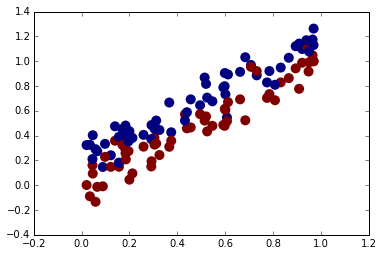

In [3]:
np.random.seed(42)
x_space = np.random.uniform(0, 1, size=60)
y0 = x_space + 0.2 + np.random.normal(size=len(x_space), scale=0.1)
y1 = x_space + np.random.normal(size=len(x_space), scale=0.1)
shuffle = np.random.permutation(2*len(x_space))
line_features = np.concatenate((np.concatenate((x_space, x_space))[:, np.newaxis],
                          np.concatenate((y0, y1))[:, np.newaxis]), axis=1)[shuffle]
line_labels = np.concatenate((np.zeros(len(y0)), np.ones(len(y1))))[shuffle]
fig, ax = plt.subplots()
ax.scatter(line_features[:, 0], line_features[:, 1], c=line_labels, edgecolors='none', s=100)

## Exhaustive GridSearch
Tries all parameters combinations. Is expensive.

In [4]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=2), {
        'criterion': ('gini', 'entropy'),
        'max_depth': (1, 5, None),
        'min_samples_split': (2, 3, 4, 5, 10),
        'n_estimators': (1, 10, 50, 100)}, scoring='roc_auc', n_jobs=4, cv=4)
grid_search_cv.fit(line_features, line_labels)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'min_samples_split': (2, 3, 4, 5, 10), 'n_estimators': (1, 10, 50, 100), 'criterion': ('gini', 'entropy'), 'max_depth': (1, 5, None)},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

Let's see how the score was improved compared to the default parameters.

In [5]:
from sklearn.cross_validation import cross_val_score
print("Evaluated CV score %d times." % len(grid_search_cv.grid_scores_))
print("Best score: %f." % grid_search_cv.best_score_)
print("Score with default parametes: %f" % 
      cross_val_score(RandomForestClassifier(random_state=2, n_jobs=4),
                      line_features, line_labels, scoring='roc_auc').mean())
grid_search_cv.best_estimator_

Evaluated CV score 120 times.
Best score: 0.728889.
Score with default parametes: 0.629167


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

Here are the scores obtained during the search. Note inefficiency - many times we calculated the points that yielded no improvement.

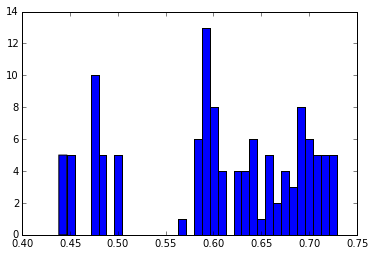

In [6]:
grid_values = map(lambda score_list: score_list.mean_validation_score, grid_search_cv.grid_scores_)
_=plt.hist(grid_values, bins=35)

## Regressor-based search
1. Fits a regressor on all evaluated points
2. Uses an optimization algorithm to find the extremum of the regressor. Please note that REP operates on the grid points.
3. Evaluates cross-validation in the regressor extremum
4. GoTo 1

In [7]:
from rep.metaml import RegressionParameterOptimizer, GridOptimalSearchCV, FoldingScorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from rep.report.metrics import RocAuc

scorer = FoldingScorer(RocAuc(), folds=4, fold_checks=4)
grid = {'criterion': ('gini', 'entropy'),
        'max_depth': (1, 5, None),
        'min_samples_split': (2, 3, 4, 5, 10),
        'n_estimators': (1, 10, 50, 100)}
generator = RegressionParameterOptimizer(grid, n_evaluations=70,
            regressor=RandomForestRegressor(), n_attempts=10)

In [8]:
grid_finder = GridOptimalSearchCV(RandomForestClassifier(random_state=2),
                                  generator, scorer, parallel_profile='threads-4')
grid_finder.fit(pd.DataFrame(line_features), line_labels)

Performing grid search in 4 threads
4 evaluations done
8 evaluations done
12 evaluations done
16 evaluations done
20 evaluations done
24 evaluations done
28 evaluations done
32 evaluations done
36 evaluations done
40 evaluations done
44 evaluations done
48 evaluations done
52 evaluations done
56 evaluations done
60 evaluations done
64 evaluations done
68 evaluations done
72 evaluations done


In [9]:
grid_finder.params_generator.best_score_

0.72888888888888892

Found the same point in 70 iterations instead of 120.

## Gaussian process
Fancy regressor - it can handle uncertainty.

A Gaussian process optimizer not stuck to the grid.
https://github.com/fmfn/BayesianOptimization/blob/master/examples/sklearn_example.py

In [10]:
from __future__ import print_function
from __future__ import division

from bayes_opt import BayesianOptimization
def rfccv(n_estimators, min_samples_split, max_depth, criterion):
    return cross_val_score(RandomForestClassifier(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_depth=int(max_depth),
            criterion=('gini' if criterion <= 0 else 'entropy'),
            random_state=2),
                           line_features, line_labels, scoring="roc_auc",
                           cv=4, n_jobs=4).mean()

rfcBO = BayesianOptimization(rfccv, {'n_estimators': (1, 101),
                                     'min_samples_split': (2, 11),
                                     'max_depth': (1, 1000),
                                     'criterion': (-1, 1)})
rfcBO.maximize(init_points=10, n_iter=50)
print('-'*53)
print('Final Results')
print('RFC: %f' % rfcBO.res['max']['max_val'])

Initialization
------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   criterion |   max_depth |   min_samples_split |   n_estimators | 
    1 | 00m00s |    0.65167 |     -0.0816 |    297.4899 |              9.4598 |        22.6060 | 
    2 | 00m00s |    0.72000 |     -0.1778 |    541.8282 |              5.1400 |        81.9324 | 
    3 | 00m00s |    0.71889 |      0.4439 |    345.8847 |              6.6944 |        79.6358 | 
    4 | 00m00s |    0.69444 |     -0.2304 |    414.7867 |              9.1504 |        64.2217 | 
    5 | 00m00s |    0.67500 |     -0.0212 |    732.6815 |              9.9594 |        38.3520 | 
    6 | 00m00s |    0.68333 |     -0.1408 |    881.7808 |              5.1030 |        28.1499 | 
    7 | 00m00s |    0.66722 |      0.4813 |    122.3739 |              6.1566 |        24.1784 | 
    8 | 00m00s |    0.70111 |      0.7259 |    635.0046 |              5.7306 |        32.8609 | 
    9 

Better result in 60 instead of 120 iterations. But please note the need to evaluate the Gaussian process which takes some time independently of the CV complexity and is the determining factor for the real speed on this toy problem.